# Tracking a 1d pendulum using Extended / Unscented Kalman filter/ smoother

This notebook demonstrates a simple pendulum tracking example.
The example is taken from p45 of 
*Bayesian Filtering and Smoothing* (S. Särkkä, 2013).
This code is based on the  [sarkka-jax](https://github.com/petergchang/sarkka-jax) repo.


The physics of the problem is shown below, where $\alpha$ is the angle relative to vertical,
and $w(t)$ is a white noise process added to the angular velocity (a random acceleration term).

![Pendulum](https://github.com/probml/dynamax/blob/main/docs/figures/pendulum.png?raw=true)

This gives rise to the following differential equation:
\begin{align*}
\frac{\mathrm{d}^2 \alpha}{\mathrm{d} t^2}
= -g \sin(\alpha) + w(t)
\end{align*}
We can write this as a nonlinear SSM by defining the state to be
$z_1(t) = \alpha(t)$ and $z_2(t) = \mathrm{d}\alpha(t)/\mathrm{d}t$.
Thus

\begin{align*}
\frac{\mathrm{d} z}{\mathrm{d}t}
= \begin{pmatrix} z_2 \\ -g \sin(z_1) \end{pmatrix}
+ \begin{pmatrix} 0 \\ 1 \end{pmatrix} w(t)
\end{align*}

If we discretize this step size $\Delta$,
we get the following formulation:

\begin{align*}
  \begin{pmatrix} z_{1,t} \\ z_{2,t} \end{pmatrix}
=
  \begin{pmatrix} z_{1,t-1} + z_{2,t-1} \Delta  \\
    z_{2,t-1} -g \sin(z_{1,t-1}) \Delta 
     \end{pmatrix}
+q_{t} 
\end{align*}






where $q_t \sim N(0,Q)$, and

\begin{equation*}
Q = q^c
\begin{pmatrix}
  \frac{\Delta^3}{3} &   \frac{\Delta^2}{2} \\
  \frac{\Delta^2}{2} & \Delta 
  \end{pmatrix} 
\end{equation*}


where $q^c$ is the spectral density 
of the continuous-time noise process.

We assume the observation model is

\begin{align*}
y_t &= h(z_t) + r_t \\
h(z_t) &=  \sin(\alpha_t)  = \sin(z_{t,1}) \\
r_t &\sim \mathrm{N}(0,R)
\end{align*}

This corresponds to receiving noisy measurements of the horizontal position of the pendulum.


We show how to perform approximate inference of the latent states in this nonlinear dynamical system model using an Extended Kalman Filter (EKF) or an Unscented Kalman Filter (UKF). These algorithms work by approximating the nonlinear model with a linear Gaussian model, with two different types of approximations. For more detail on these algorithms, see Murphy (2023) or Särkkä and Svensson (2023).

## References
- Murphy, Kevin P. Probabilistic machine learning: Advanced topics. MIT press, 2023.
- Särkkä, Simo, and Lennart Svensson. Bayesian filtering and smoothing. Vol. 17. Cambridge university press, 2023.



## Setup

In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from jax import lax
from jaxtyping import Float, Array
from typing import Callable, NamedTuple

from dynamax.nonlinear_gaussian_ssm import ParamsNLGSSM, UKFHyperParams
from dynamax.nonlinear_gaussian_ssm import extended_kalman_smoother as ekf
from dynamax.nonlinear_gaussian_ssm import unscented_kalman_smoother as ukf

In [3]:
# For pretty print of ndarrays
jnp.set_printoptions(formatter={"float_kind": "{:.2f}".format})

## Sample data and plot it

In [4]:
# Some parameters
dt = 0.0125
g = 9.8
q_c = 1
r = 0.3

# Lightweight container for pendulum parameters
class PendulumParams(NamedTuple):
    initial_state: Float[Array, "state_dim"] = jnp.array([jnp.pi / 2, 0])
    dynamics_function: Callable = lambda x: jnp.array([x[0] + x[1] * dt, x[1] - g * jnp.sin(x[0]) * dt])
    dynamics_covariance: Float[Array, "state_dim state_dim"] = jnp.array([[q_c * dt**3 / 3, q_c * dt**2 / 2], [q_c * dt**2 / 2, q_c * dt]])
    emission_function: Callable = lambda x: jnp.array([jnp.sin(x[0])])
    emission_covariance: Float[Array, "emission_dim"] = jnp.eye(1) * (r**2)

In [5]:
# Pendulum simulation (Särkkä Example 3.7)
def simulate_pendulum(params=PendulumParams(), key=0, num_steps=400):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    # Unpack parameters
    M, N = params.initial_state.shape[0], params.emission_covariance.shape[0]
    f, h = params.dynamics_function, params.emission_function
    Q, R = params.dynamics_covariance, params.emission_covariance

    def _step(carry, rng):
        state = carry
        rng1, rng2 = jr.split(rng, 2)

        next_state = f(state) + jr.multivariate_normal(rng1, jnp.zeros(M), Q)
        obs = h(next_state) + jr.multivariate_normal(rng2, jnp.zeros(N), R)
        return next_state, (next_state, obs)

    rngs = jr.split(key, num_steps)
    _, (states, observations) = lax.scan(_step, params.initial_state, rngs)
    return states, observations


states, obs = simulate_pendulum()

In [7]:
def plot_pendulum(time_grid, x_tr, x_obs, x_est=None, est_type=""):
    plt.figure()
    plt.plot(time_grid, x_tr, color="darkgray", linewidth=4, label="True Angle")
    plt.plot(time_grid, x_obs, "ok", fillstyle="none", ms=1.5, label="Measurements")
    if x_est is not None:
        plt.plot(time_grid, x_est, color="k", linewidth=1.5, label=f"{est_type} Estimate")
    plt.xlabel("Time $t$")
    plt.ylabel("Pendulum angle $x_{1,k}$")
    plt.xlim(0, 5)
    plt.ylim(-3, 5)
    plt.xticks(jnp.arange(0.5, 4.6, 0.5))
    plt.yticks(jnp.arange(-3, 5.1, 1))
    plt.gca().set_aspect(0.5)
    plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k")
    plt.show()

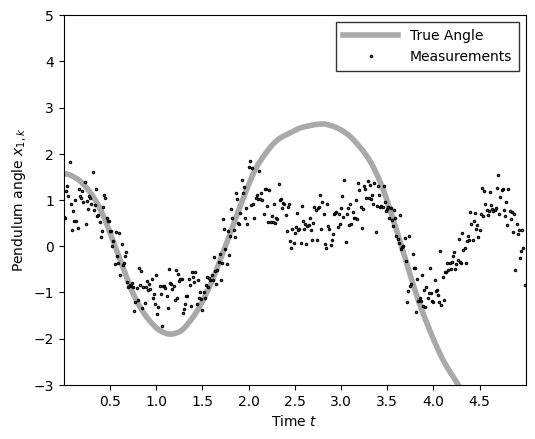

In [8]:
# Create time grid for plotting
time_grid = jnp.arange(0.0, 5.0, step=dt)

# Plot the generated data
plot_pendulum(time_grid, states[:, 0], obs)

### Helper fucntions for evaluating estimates

We use the functions below to compute and print the errors associated with various state estimates.

In [17]:
# Compute RMSE
def compute_rmse(y, y_est):
    return jnp.sqrt(jnp.sum((y - y_est) ** 2) / len(y))


# Compute RMSE of estimate and print comparison with
# standard deviation of measurement noise
def compute_and_print_rmse_comparison(y, y_est, R, est_type=""):
    rmse_est = compute_rmse(y, y_est)
    print(f"The RMSE of the {est_type} estimate is: {rmse_est:.2f}")
    print(f"The std of measurement noise is: {jnp.sqrt(R):.2f}")

## Extended Kalman Filter / Smoother

The extended Kalman filter (EKF) is an approximate inference algorithm for systems with nonlinear dynamics and/or emissions and Gaussian noise. It works by using a first-order Taylor approximation to the dynamics and/or emissions functions, and the n running a standard Kalman filter on the "linearized" model. The EKF tends to work well when the dynamics and emissions are well-approximated by their first-order Taylor function around the predictive means, and when the Jacobians of these functions are available. Dynamax uses automatic differentiation to compute these Jacobians.

The _filter_ computes estimates of the latent states based on observations up to and including time $t$, whereas the _smoother_ estimates states based on all observations through time $T$.
\begin{align*}
p(z_t \mid y_{1:t}; \theta) & & & \text{(filter)} \\
p(z_t \mid y_{1:T}; \theta) & & & \text{(smoother)}
\end{align*}

In [18]:
pendulum_params = PendulumParams()

# Define parameters for EKF
ekf_params = ParamsNLGSSM(
    initial_mean=pendulum_params.initial_state,
    initial_covariance=jnp.eye(states.shape[-1]) * 0.1,
    dynamics_function=pendulum_params.dynamics_function,
    dynamics_covariance=pendulum_params.dynamics_covariance,
    emission_function=pendulum_params.emission_function,
    emission_covariance=pendulum_params.emission_covariance,
)

ekf_posterior = ekf(ekf_params, obs)

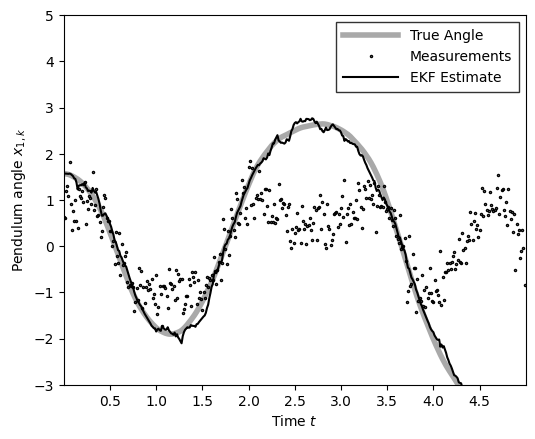

The RMSE of the EKF estimate is: 0.13
The std of measurement noise is: 0.55


In [19]:
m_ekf = ekf_posterior.filtered_means[:, 0]
plot_pendulum(time_grid, states[:, 0], obs, x_est=m_ekf, est_type="EKF")
compute_and_print_rmse_comparison(states[:, 0], m_ekf, r, "EKF")

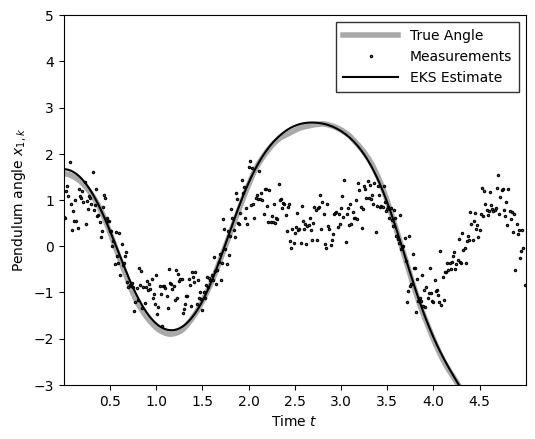

The RMSE of the EKS estimate is: 0.06
The std of measurement noise is: 0.55


In [20]:
m_ekf = ekf_posterior.smoothed_means[:, 0]
plot_pendulum(time_grid, states[:, 0], obs, x_est=m_ekf, est_type="EKS")
compute_and_print_rmse_comparison(states[:, 0], m_ekf, r, "EKS")

## Unscented Kalman Filter / Smoother

The Unscented Kalman Filter (UKF) works by matching moments of a Gaussian approximation to the filtering and predictive distributions. Briefly, the UKF passes a grid of _sigma points_ through the dynamics and emissions functions, and then uses the weighted mean and covariance of the transformed points to form the Gaussian approximation. 

Should you use an EKF or a UKF for your problem? Särkkä (2023; pg. 160) says the following,
> the unscented transform is able to capture the higher order moments caused by the non-linear transform better than Taylor series-based approximations. However, as already pointed out in the previous section, although the mean estimate of the UKF is exact for polynomials up to order three, the covariance computation is only exact for polynomials up to first order. In the UKF, the dynamic and model functions are also not required to be formally differentiable nor do their Jacobian matrices need to be computed. The disadvantage over the EKF is that the UKF often re quires slightly more computational operations than the EKF.

Furthermore, as we demonstrate below, the UKF is sensitive to the choice of hyperparameters that determine the sigma points, whereas the EKF is essentially hyperparameter-free.

Finally, as above, you can use either the Unscented Kalman Filter (UKF) or the Unscented Kalman Smoother (UKS) depending on whether you want a causal or acausal state estimate.

In [23]:
pendulum_params = PendulumParams()

ukf_params = ParamsNLGSSM(
    initial_mean=pendulum_params.initial_state,
    initial_covariance=jnp.eye(states.shape[-1]) * 0.1,
    dynamics_function=pendulum_params.dynamics_function,
    dynamics_covariance=pendulum_params.dynamics_covariance,
    emission_function=pendulum_params.emission_function,
    emission_covariance=pendulum_params.emission_covariance,
)

# In this example, the default gives the same results as EKF
ukf_hyperparams = UKFHyperParams() 
ukf_posterior = ukf(ukf_params, obs, ukf_hyperparams)

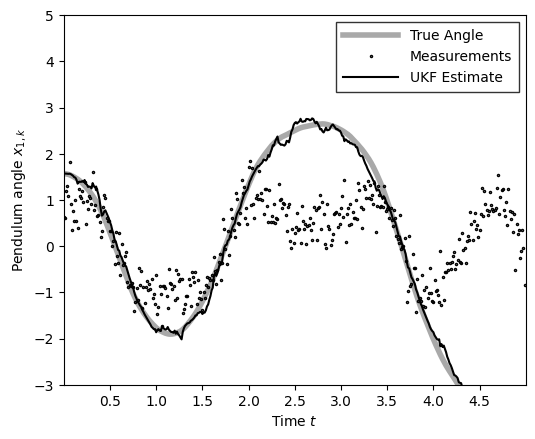

The RMSE of the UKF estimate is: 0.13
The std of measurement noise is: 0.55


In [24]:
m_ukf = ukf_posterior.filtered_means[:, 0]
plot_pendulum(time_grid, states[:, 0], obs, x_est=m_ukf, est_type="UKF")
compute_and_print_rmse_comparison(states[:, 0], m_ukf, r, "UKF")

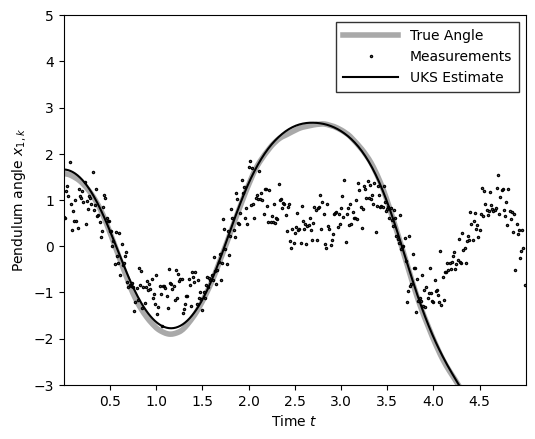

The RMSE of the UKS estimate is: 0.06
The std of measurement noise is: 0.55


In [ ]:
m_uks = ukf_posterior.smoothed_means[:, 0]
plot_pendulum(time_grid, states[:, 0], obs, x_est=m_uks, est_type="UKS")
compute_and_print_rmse_comparison(states[:, 0], m_uks, r, "UKS")

### Hyperparameters

The sigma points in the UKF/UKS are based on hyperparameters $(\alpha, \beta, \kappa)$, which are detailed in the textbooks above. These hyperparameters can have a significant effect on the state estimates, so you may consider testing a range of settings based on your problem. Again, see the books above for more detail.

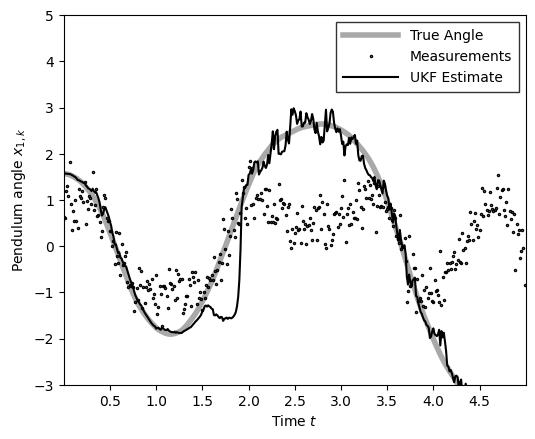

The RMSE of the UKF estimate is: 0.43
The std of measurement noise is: 0.55


In [26]:
# Let's see how sensitive UKF is to hyper-params
ukf_hyperparams = UKFHyperParams(alpha=3, beta=3, kappa=3)
ukf_posterior = ukf(ukf_params, obs, ukf_hyperparams)

m_ukf = ukf_posterior.filtered_means[:, 0]
plot_pendulum(time_grid, states[:, 0], obs, x_est=m_ukf, est_type="UKF")
compute_and_print_rmse_comparison(states[:, 0], m_ukf, r, "UKF")

## Conclusion

This notebook shows how to use the extended and unscented Kalman filter/smoother to infer latent states of a canonical nonlinear dynamical system, a simple pendulum. We saw that the smoothers achieved lower error estimates by considering future observations, but of course that renders them acausal. We also showed how to adjust the UKF hyperparameters, in case the defaults don't work for your problem.